In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [63]:

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [64]:
# LOAD DATA FROM CSV
def load_data_from_csv(file_path):
    df = pd.read_csv(file_path)
    # df = df.iloc[:len(df) // 100]
    df = df[['date','open', 'high', 'low', 'close']]  # Ensure we have the necessary columns
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    first_date = df['date'].iloc[0].date()
    df= df[df['date'].dt.date != first_date]

    
    return df

In [65]:
file_path = 'ONGC_minute_data_with_indicators.csv'  # Update with the path to your CSV file
aapl = load_data_from_csv(file_path)

In [66]:
aapl.head()

,date,open,high,low,close
312,2015-02-03 09:15:00,235.07,235.67,234.67,234.90
313,2015-02-03 09:16:00,234.70,235.53,234.70,235.33
314,2015-02-03 09:17:00,235.53,236.00,235.30,236.00
315,2015-02-03 09:18:00,236.00,236.00,235.53,235.97
316,2015-02-03 09:19:00,235.90,236.07,235.80,235.87


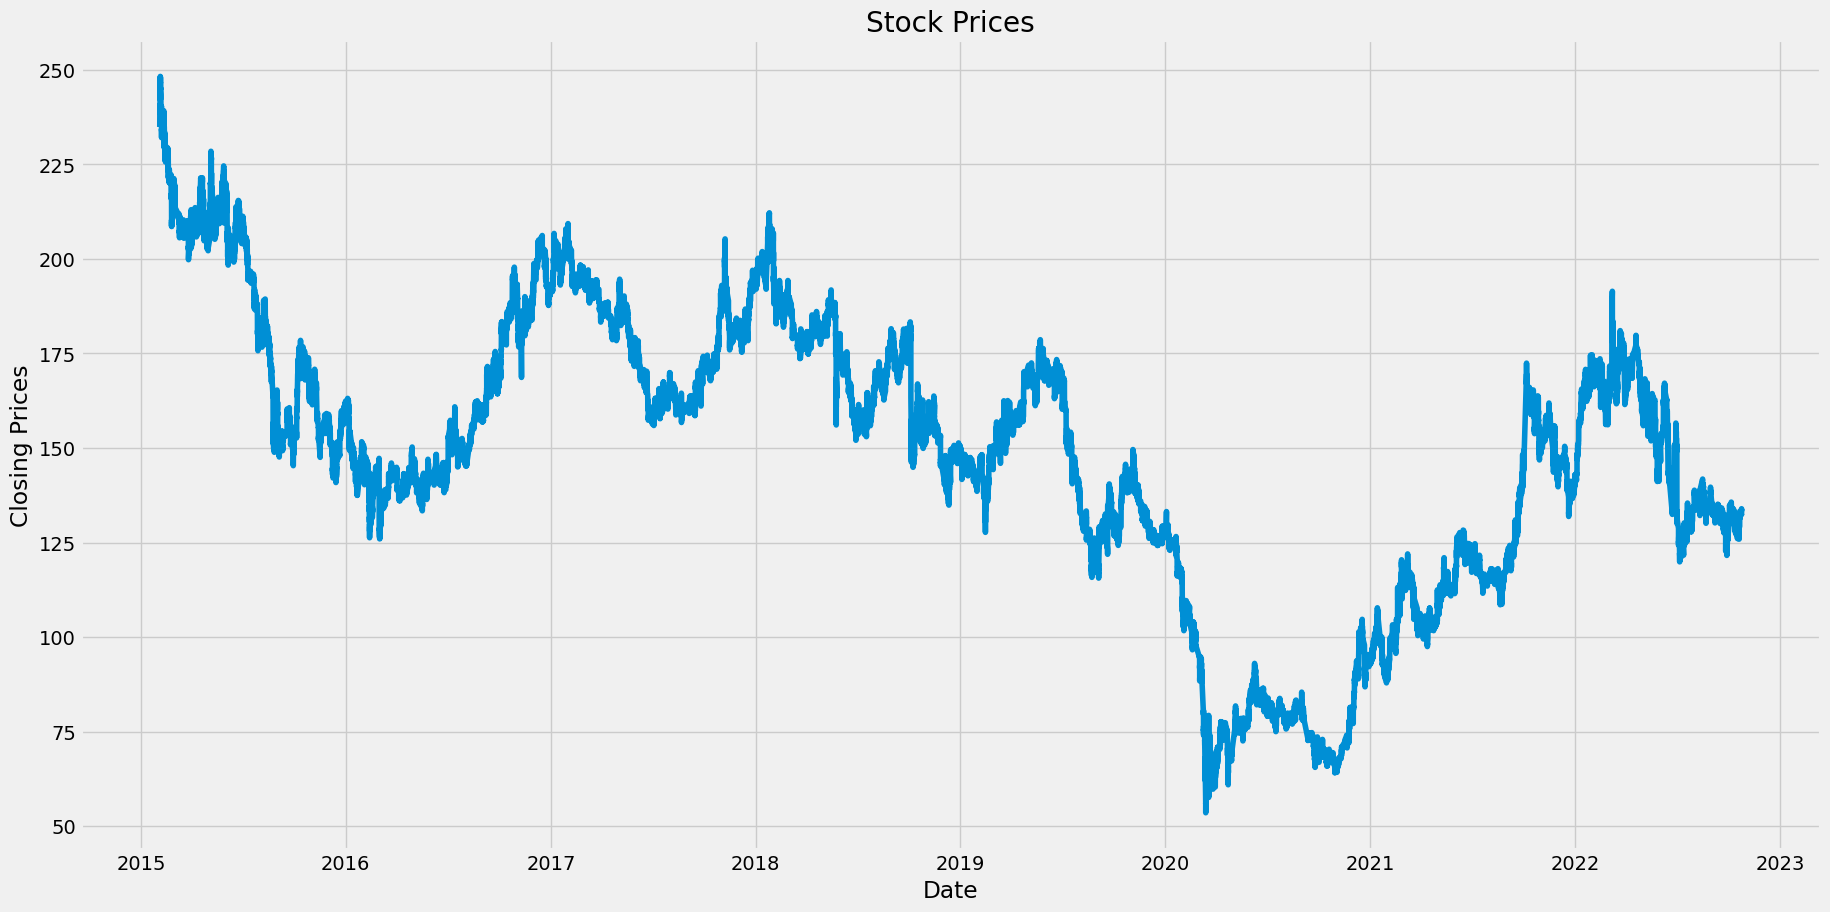

In [67]:
plt.plot(aapl['date'], aapl['close'])
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Stock Prices')
plt.show()

In [68]:
# Calculate Simple Moving Average (SMA)
def sma(data, window):
    return data.rolling(window=window).mean()

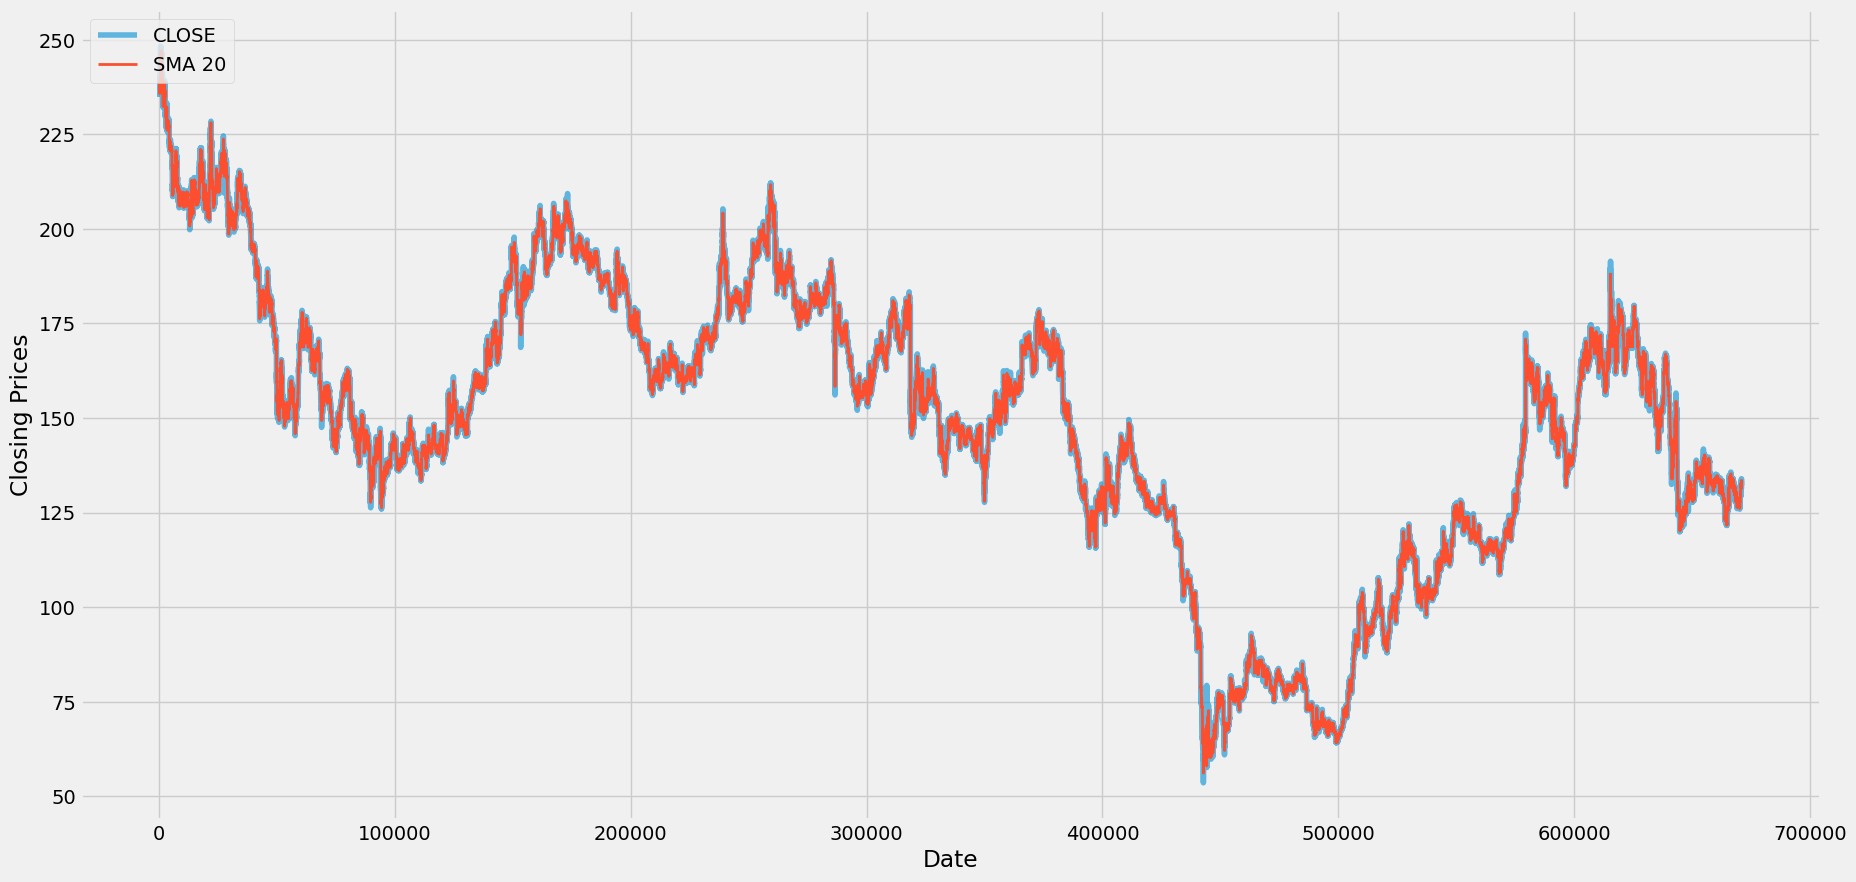

In [69]:
aapl['sma_20'] = sma(aapl['close'], 20)

# Plot close price and SMA
aapl['close'].plot(label='CLOSE', alpha=0.6)
aapl['sma_20'].plot(label='SMA 20', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend(loc='upper left')
plt.show()

In [70]:
def bb(data, sma, window):
    std = data.rolling(window=window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

aapl['upper_bb'], aapl['lower_bb'] = bb(aapl['close'], aapl['sma_20'], 20)



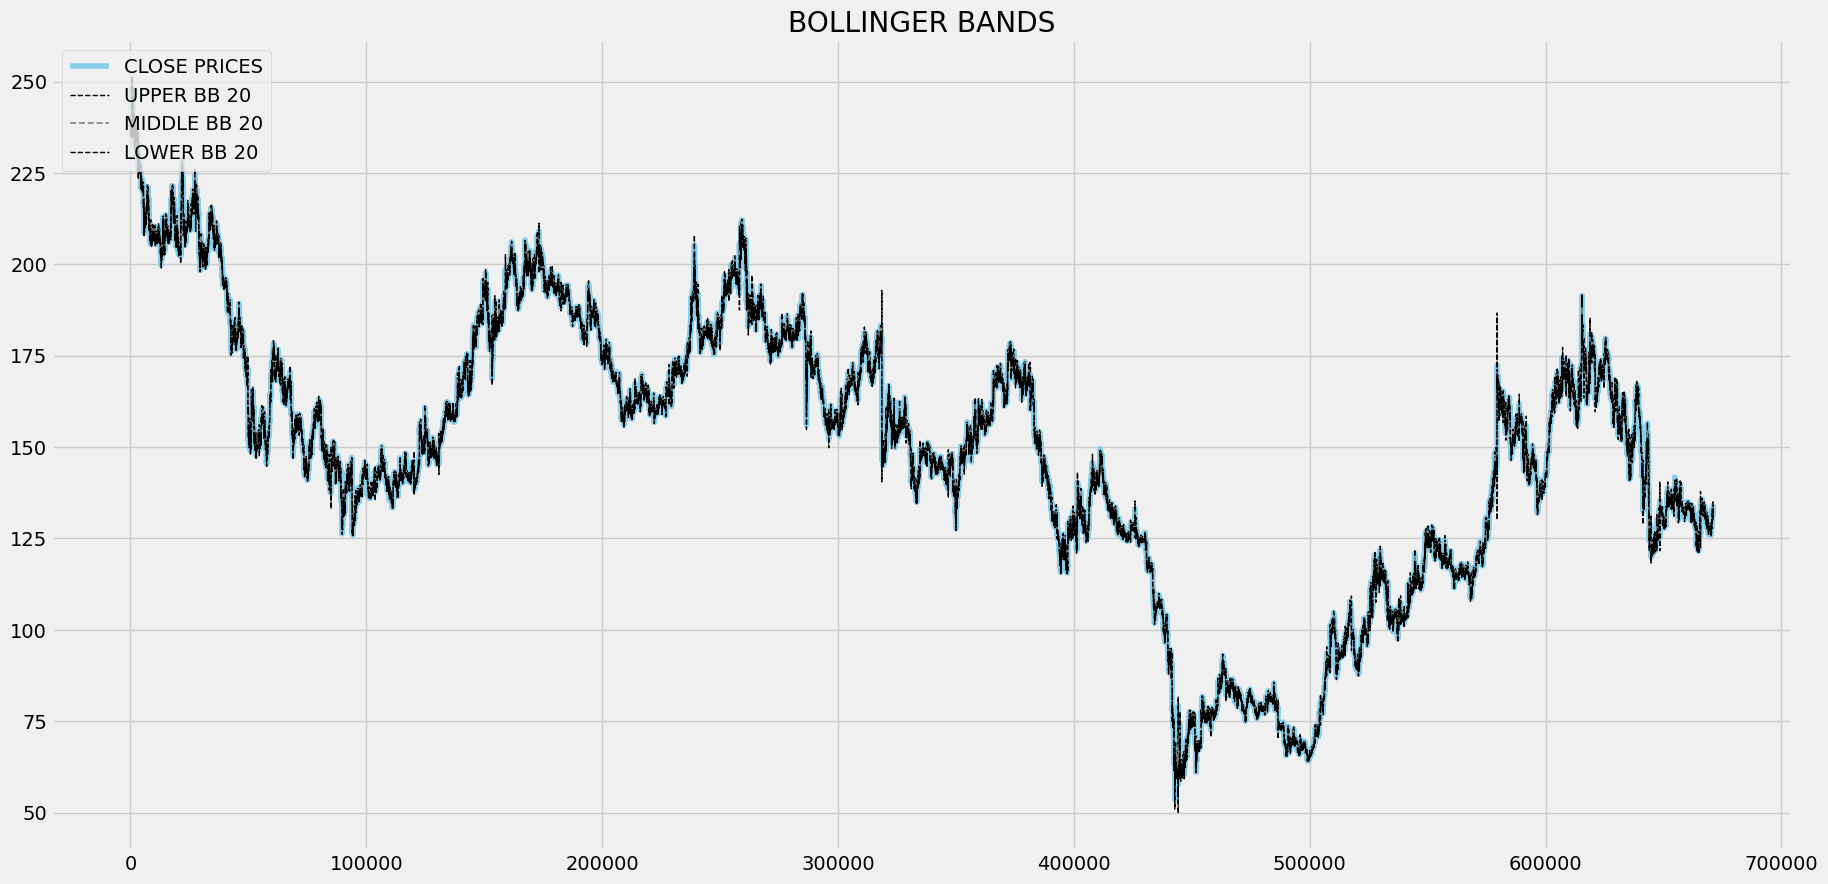

In [71]:
# Plot Bollinger Bands
aapl['close'].plot(label='CLOSE PRICES', color='skyblue')
aapl['upper_bb'].plot(label='UPPER BB 20', linestyle='--', linewidth=1, color='black')
aapl['sma_20'].plot(label='MIDDLE BB 20', linestyle='--', linewidth=1.2, color='grey')
aapl['lower_bb'].plot(label='LOWER BB 20', linestyle='--', linewidth=1, color='black')
plt.legend(loc='upper left')
plt.title('BOLLINGER BANDS')
plt.show()

In [72]:
# Ensure all series have aligned indices and no NaN values in required columns
aapl.dropna(subset=['close', 'lower_bb', 'upper_bb'], inplace=True)

# Implement Bollinger Bands Strategy
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    # Start from the second element to avoid indexing issues
    for i in range(1, len(data)):
        if data.iloc[i - 1] > lower_bb.iloc[i - 1] and data.iloc[i] < lower_bb.iloc[i]:
            if signal != 1:
                buy_price.append(data.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data.iloc[i - 1] < upper_bb.iloc[i - 1] and data.iloc[i] > upper_bb.iloc[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data.iloc[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)

    # Add NaN to the beginning to match length
    buy_price.insert(0, np.nan)
    sell_price.insert(0, np.nan)
    bb_signal.insert(0, 0)

    return buy_price, sell_price, bb_signal

# Apply the strategy
buy_price, sell_price, bb_signal = implement_bb_strategy(aapl['close'], aapl['lower_bb'], aapl['upper_bb'])


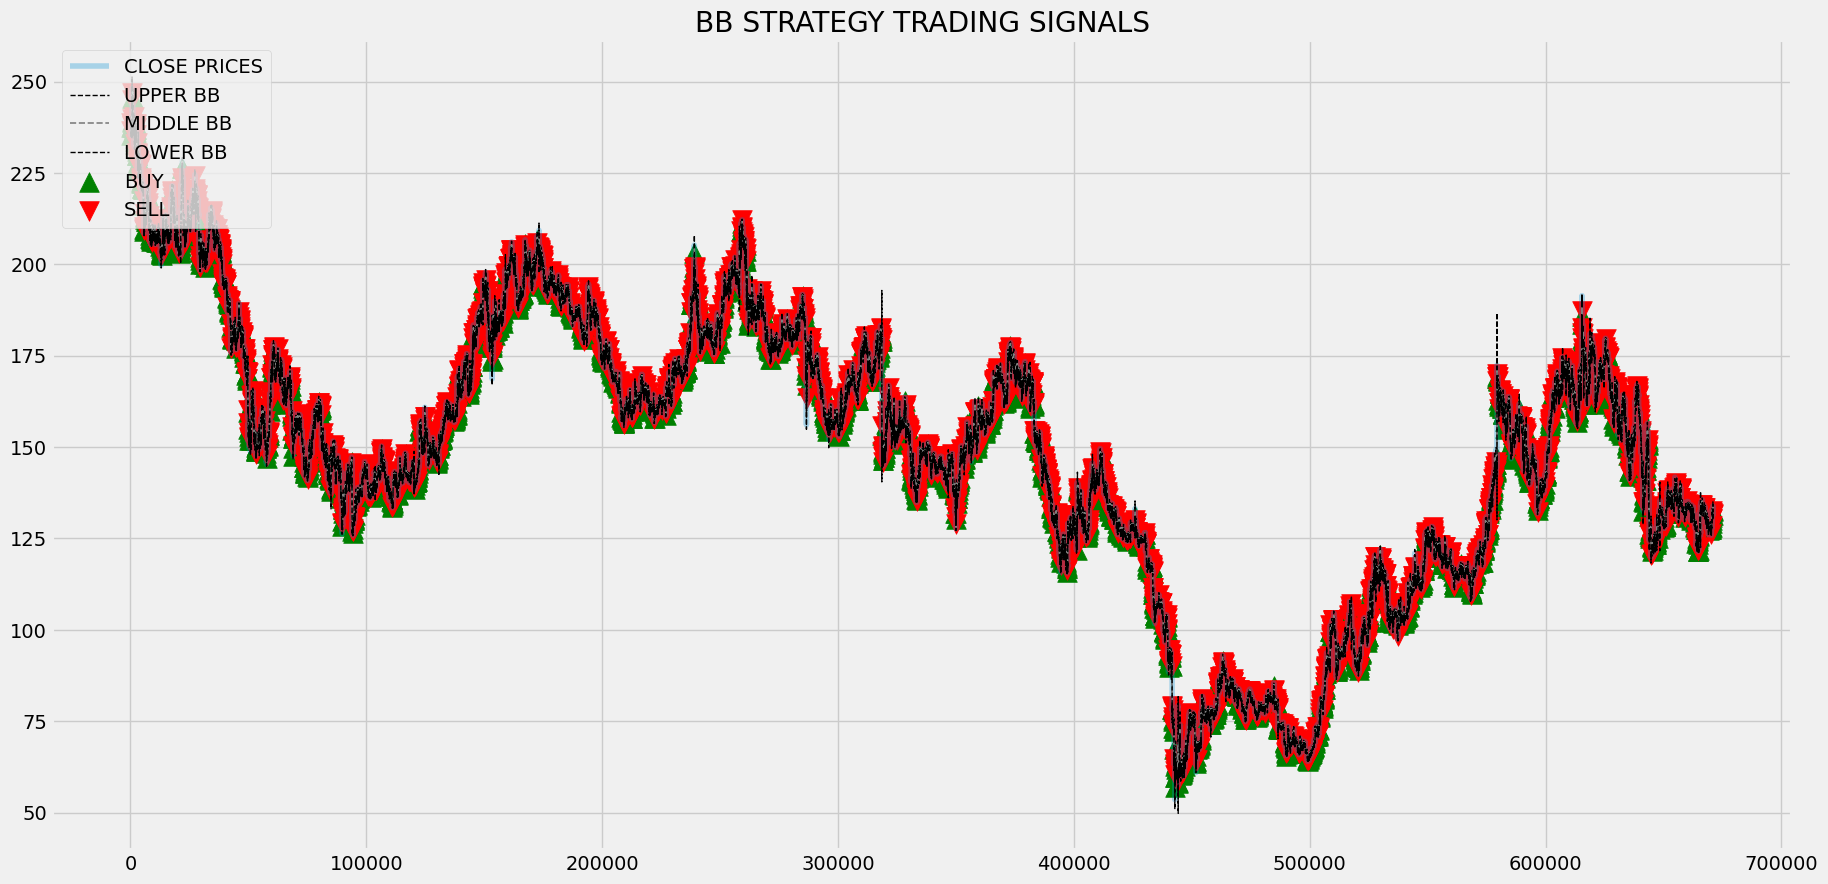

In [73]:
aapl['close'].plot(label='CLOSE PRICES', alpha=0.3)
aapl['upper_bb'].plot(label='UPPER BB', linestyle='--', linewidth=1, color='black')
aapl['sma_20'].plot(label='MIDDLE BB', linestyle='--', linewidth=1.2, color='grey')
aapl['lower_bb'].plot(label='LOWER BB', linestyle='--', linewidth=1, color='black')
plt.scatter(aapl.index, buy_price, marker='^', color='green', label='BUY', s=200)
plt.scatter(aapl.index, sell_price, marker='v', color='red', label='SELL', s=200)
plt.title('BB STRATEGY TRADING SIGNALS')
plt.legend(loc='upper left')
plt.show()

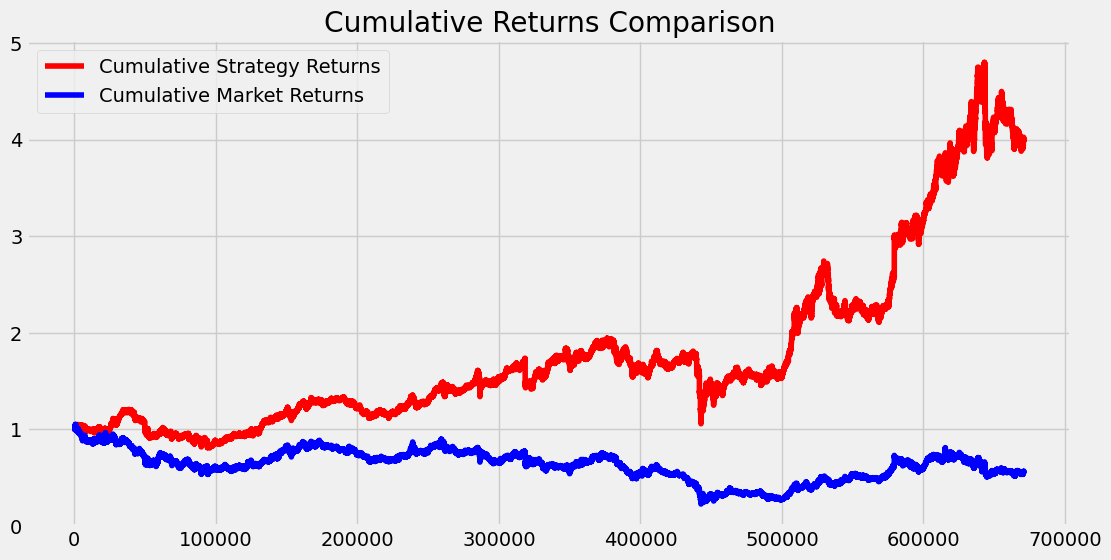

In [74]:
# Ensure bb_signal is a pandas Series and flatten it if needed
bb_signal = pd.Series(np.ravel(bb_signal), index=aapl.index)  # Flatten the array if necessary

# Calculate strategy returns
position = np.zeros(len(bb_signal))  # Initialize position array

# Update position based on buy/sell signals
for i in range(1, len(bb_signal)):
    if bb_signal.iloc[i] == 1:  # Buy signal
        position[i] = 1
    elif bb_signal.iloc[i] == -1:  # Sell signal
        position[i] = 0
    else:
        position[i] = position[i - 1]  # Hold position

# Convert to DataFrame for easier handling
position_df = pd.DataFrame(position, index=aapl.index, columns=['bb_position'])

# Calculate returns
rets = aapl['close'].pct_change().dropna()  # Daily returns of the closing price
strat_rets = position_df['bb_position'].shift(1) * rets  # Strategy returns

# Optionally: Calculate cumulative returns
cumulative_strategy_rets = (1 + strat_rets).cumprod()
cumulative_market_rets = (1 + rets).cumprod()

# Plot returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy_rets, label='Cumulative Strategy Returns', color='red')
plt.plot(cumulative_market_rets, label='Cumulative Market Returns', color='blue')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.show()


In [75]:
# Count number of trades
num_trades = bb_signal.value_counts().get(1, 0) + bb_signal.value_counts().get(-1, 0)

# Output the results
print(f'Number of Buy Trades: {bb_signal.value_counts().get(1, 0)}')
print(f'Number of Sell Trades: {bb_signal.value_counts().get(-1, 0)}')
print(f'Total Number of Trades: {num_trades}')


Number of Buy Trades: 6943
Number of Sell Trades: 6942
Total Number of Trades: 13885


In [76]:
# Create a list to hold trade data
trades_list = []

# Iterate over the signals to identify trades
for i in range(len(bb_signal)):
    if bb_signal.iloc[i] == 1:  # Buy signal
        buy_price = aapl['close'].iloc[i]
        trades_list.append({'Buy Price': buy_price, 'Sell Price': np.nan, 'Profit/Loss': np.nan})
    elif bb_signal.iloc[i] == -1:  # Sell signal
        if trades_list and pd.isna(trades_list[-1]['Sell Price']):  # Check if there's a pending buy
            sell_price = aapl['close'].iloc[i]
            trades_list[-1]['Sell Price'] = sell_price  # Set the sell price
            trades_list[-1]['Profit/Loss'] = sell_price - trades_list[-1]['Buy Price']  # Calculate profit/loss

# Convert the list of trades to a DataFrame
trades = pd.DataFrame(trades_list)

# Count correct and incorrect trades
correct_trades = trades[trades['Profit/Loss'] > 0].shape[0]
incorrect_trades = trades[trades['Profit/Loss'] < 0].shape[0]

# Output the results
print(f'Number of Correct Trades: {correct_trades}')
print(f'Number of Incorrect Trades: {incorrect_trades}')


Number of Correct Trades: 4488
Number of Incorrect Trades: 2276
